In [158]:
import pandas as pd
import numpy as np
import datetime

#api
import praw

#pre-processing
import nltk 
from nltk.util import ngrams
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tree import Tree
from nltk.stem.porter import *
from nltk.tokenize import MWETokenizer 
from nltk import word_tokenize, pos_tag, ne_chunk
import spacy
# from spacy import displacy
import en_core_web_sm
import re
# import string
#from textblob import TextBlob
#from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim
from collections import Counter
# nltk.download()

from NLP_functions import display_topics, prob_df, topic_matrix

#analysis
from sklearn.decomposition import TruncatedSVD, NMF

#plotting
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from NLP_functions import display_topics, prob_df, topic_matrix

In [3]:
reddit = praw.Reddit(client_id='oCxykEUclueAuA', client_secret='M8wVQw3nFxMsXHLGxurnTtkN-Mdvtg', user_agent='Crypto')

Version 7.0.0 of praw is outdated. Version 7.1.4 was released Sunday February 07, 2021.


#### Get top posts of all time

In [4]:
posts = []
ml_subreddit = reddit.subreddit('Cryptocurrency')

for post in list(ml_subreddit.top('all', limit=1000)):
    date = datetime.datetime.utcfromtimestamp(post.created_utc)
    posts.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, date])
    
posts = pd.DataFrame(posts,columns=['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'date'])
print(posts)

                                                 title  score      id  \
0    Elon Musk reminds me of a rich billionaire who...  39345  lce6zm   
1    CryptoNick is deleting all of his BitConnect v...  26497  7r0ftz   
2    Reminder: Robinhood blocked several stocks fro...  26301  lfrslo   
3              My wife joined the communists this year  22288  lotjbj   
4                                     It’s inevitable.  20644  lo75z9   
..                                                 ...    ...     ...   
927                           HODL is all I have left.   1520  aor9w7   
928                    "Bitcoin is a fraud and a scam"   1519  70i6o6   
929            Let me get this straight about Verge...   1523  8af0gc   
930  Coinmetrics report: Over 2 million Bitcoin Pri...   1510  a8yuuh   
931  Google suspends most widely adopted Ethereum/E...   1517  eg4hkw   

          subreddit                                                url  \
0    CryptoCurrency  https://www.reddit.com/r/Cry

#### Get top coments from each top post, group by post

In [5]:
# top_posts = []
# for i,d in zip(posts.id, posts.date):
#     try:
#         submission = reddit.submission(id=i)
#         submission.comments.replace_more(limit=0)
#         comments=list([(comment.body) for comment in submission.comments.list()])
#         comment_string = ''
#         for x in comments[:20]:
#             comment_string = comment_string + ' ' + x
#         top_posts.append([comment_string,d])
#     except:
#         comments=None
# top_posts = pd.DataFrame(top_posts, columns=['comment', 'date'])
# print(top_posts)

#### Get top coments from each top post

In [6]:
all_top_comments = []
for i,d in zip(posts.id, posts.date):
    try:
        submission = reddit.submission(id=i)
        submission.comments.replace_more(limit=0)
        comments=list([(comment.body) for comment in submission.comments.list()])
        for x in comments[:20]:
            all_top_comments.append([x,d])
#             print(all_top_comments)
    except:
        comments=None
all_top_comments = pd.DataFrame(all_top_comments,columns=['comment', 'date'])
print(all_top_comments)

                                                 comment                date
0      If your life savings hinges on a Tweet from a ... 2021-02-04 12:02:16
1      I seriously don’t understand the obsession wit... 2021-02-04 12:02:16
2      Tbh u can't place all the blame on Elon tho, t... 2021-02-04 12:02:16
3      seriously, there's so much more relevant peopl... 2021-02-04 12:02:16
4      If I'm Elon, I put hundreds of millions into D... 2021-02-04 12:02:16
...                                                  ...                 ...
18616  Google releasing their own currency in 3... 2.... 2019-12-27 01:46:48
18617                  buy signal for eth and solid alts 2019-12-27 01:46:48
18618  It is strange to see that this occurs at the s... 2019-12-27 01:46:48
18619                                          [deleted] 2019-12-27 01:46:48
18620  It is available on Brave still or? Out of the ... 2019-12-27 01:46:48

[18621 rows x 2 columns]


## Cleaning

add year column

In [7]:
# top_comments['year'] = top_comments['date'].dt.year
# years = ['2017', '2018', '2019', '2020', '2021']
# top_comments['year'].value_counts()

In [125]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [483]:
stop = stopwords.words('english')
stop += [ 'moderator', 'subreddit', 'reddit' , 'question', 'concern', 'please', 'contact', 'im', 
            'people', 'gon', 'seems', 'something', 'year', 'like', 'mod', 'wa', 'thread', 'crypto', 'get',
            'see', 'deleted', 'ha', 'use', 'think', 'cryptocurrency', 'thing', 'one', 'even', 'want', 'need',
        'time', 'also', 'got', 'post', 'thats', 'probably', 'u', 'every', 'next', 'reason', 'na', 'give', 'lol',
        'everything', 'know', 'community', 'today', 'come', 'anyone', 'actually', 'removed', 'wtf', 'immage',
        'really', 'nice', 'man', 'work', 'day', 'way', 'would', 'could', 'said', 'submission', 'news', 'nice',
        'enjoy', 'find', 'work', 'job', 'flaired', 'inaccurately', 'click', 'action', 'performed', 'automatically',
        'ive', 'seen', 'sense', 'month', 'pretty', 'much', 'week']
stop = set(stop)

# mwe_tokenizer = MWETokenizer([ ('bull','run'), ('market','cap'), ('pump','dump'), ('bitcoin','cash'),
#                              ('stock','market'), ('flaired', 'inaccurately'), ('make','money'), ('going','up'),
#                              ('going', 'down'), ('make','money'), ('go','up'), ('go', 'down'), ('dont', 'know')])
mwe_tokenizer = MWETokenizer(('bitcoin','cash'))

# Init Lemmatizer and stemmer
lemmatizer = nltk.stem.WordNetLemmatizer()
stemmer = PorterStemmer()

In [484]:
def clean_str_list(row):
#     for s in str_list:
    s = str(row[0]).lower() #lowercase
        
    s = re.sub(r'\([^)]*\)', '', s) #remove links
        
    #only alphabetical letters
    NON_ASCII = re.compile(r'[^a-z0-1\s]')
    s = NON_ASCII.sub(r'', s)
    
    s = re.sub(r'[0-9]+', '', s)
        
    #replace acronyms 
#     s = s.replace('btc', 'bitcoin') 
#     s = s.replace('bch', 'bitcoin cash')
#     s = s.replace('eth', 'ethereum')
#     s = s.replace(' alt ', 'altcoins')
  
    s_token = mwe_tokenizer.tokenize(word_tokenize(s))  # tokenize words
    
    s_token = [w.strip() for w in s_token] #remove spaces
    
    s_token = [w for w in s_token if w not in stop] #remove stop words
        
    # Lemmatize and stem Single Word with the appropriate POS tag
#     s_token_lemm = [stemmer.stem(lemmatizer.lemmatize(w, get_wordnet_pos(w))) for w in s_token]
    s_token_lemm = [lemmatizer.lemmatize(w) for w in s_token]
        
    s_token_lemm = [w for w in s_token_lemm if w not in stop] #remove stop words
    
    s_lemm = " ".join(s_token_lemm) #join back into one string
        
    return s_lemm

In [485]:
top_comments = all_top_comments.copy()
top_comments['cleaned_comments'] = top_comments.apply (lambda row: clean_str_list(row), axis=1)
# top_comments['cleaned_comments'] = top_comments.apply(clean_str_list) 

Named Entitiy Recognition

In [486]:
def nouns_only(row):
    s= str(row[2]).lower()
    
    s = re.sub(r'\([^)]*\)', '', s) #remove links
        
    #only alphabetical letters
    NON_ASCII = re.compile(r'[^a-z0-1\s]')
    s = NON_ASCII.sub(r'', s)
        
    #replace acronyms 
    s = s.replace('btc', 'Bitcoin') 
    s = s.replace('bch', 'Bitcoin Cash') 
    s = s.replace(' eth ', ' Ethereum ')
#     s = s.replace('elon musk', 'elon')
    
    s_token = mwe_tokenizer.tokenize(word_tokenize(s))  # tokenize words
    s_token = nltk.pos_tag(s_token)
    
    nouns = []
    for x in s_token:
        if x[1] == 'NN' and x[1] not in stop:
            nouns.append(x[0])
    
    return ' '.join([word for word in nouns])

In [487]:
top_comments['nouns'] = top_comments.apply (lambda row: nouns_only(row), axis=1)

In [488]:
top_comments

,comment,date,cleaned_comments,nouns
0,If your life savings hinges on a Tweet from a ...,2021-02-04 12:02:16,life saving hinge tweet crazy billionaire dont...,life hinge tweet billionaire dont tell
1,I seriously don’t understand the obsession wit...,2021-02-04 12:02:16,seriously dont understand obsession elon musk ...,obsession elon musk space doesnt amount tweet ...
2,"Tbh u can't place all the blame on Elon tho, t...",2021-02-04 12:02:16,tbh cant place blame elon tho deciding yolo li...,tbh place blame elon tho life life havent twee...
3,"seriously, there's so much more relevant peopl...",2021-02-04 12:02:16,seriously relevant cryptodltfintech world obse...,cryptodltfintech world whale
4,"If I'm Elon, I put hundreds of millions into D...",2021-02-04 12:02:16,elon put hundred million doge dip tweet doge p...,elon doge dip tweet pull gain hour
...,...,...,...,...
18616,Google releasing their own currency in 3... 2....,2019-12-27 01:46:48,google releasing currency,google releasing currency
18617,buy signal for eth and solid alts,2019-12-27 01:46:48,buy signal eth solid alt,solid alt
18618,It is strange to see that this occurs at the s...,2019-12-27 01:46:48,strange occurs google purge youtube formal att...,purge youtube attack industry play store worse...
18619,[deleted],2019-12-27 01:46:48,,


### EDA of all Comments to get stop words

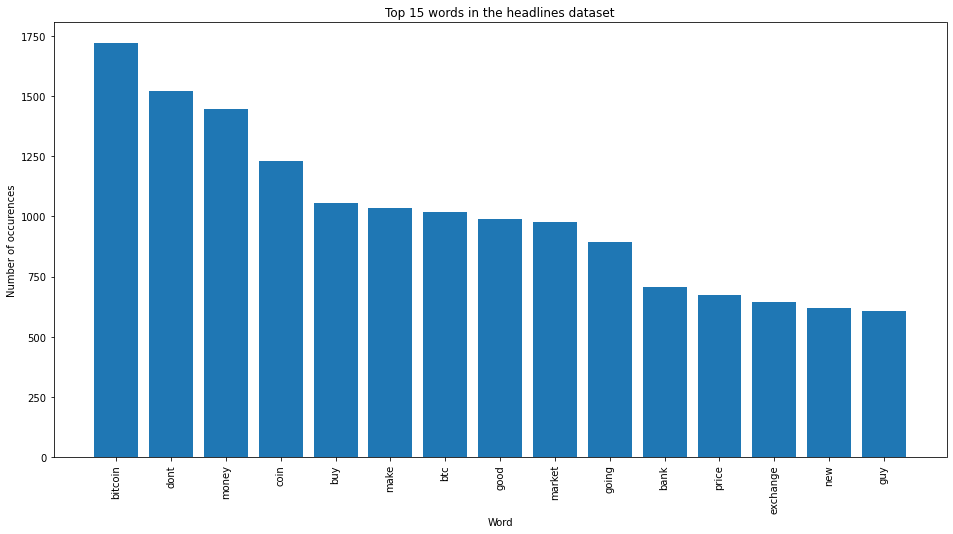

In [489]:
def get_top_n_words(corpus, n=10):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

words = []
word_values = []
for i,j in get_top_n_words(top_comments['cleaned_comments'],15):
    words.append(i)
    word_values.append(j)
    
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top 15 words in the headlines dataset');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

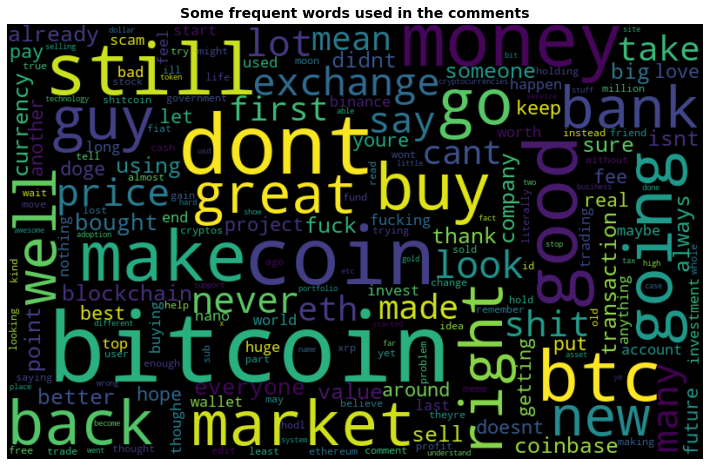

In [490]:
all_words = ' '.join([word for word in top_comments['cleaned_comments']])
all_words
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
# wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', 
#                       colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(text)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent words used in the comments", weight='bold', fontsize=14)
plt.show()

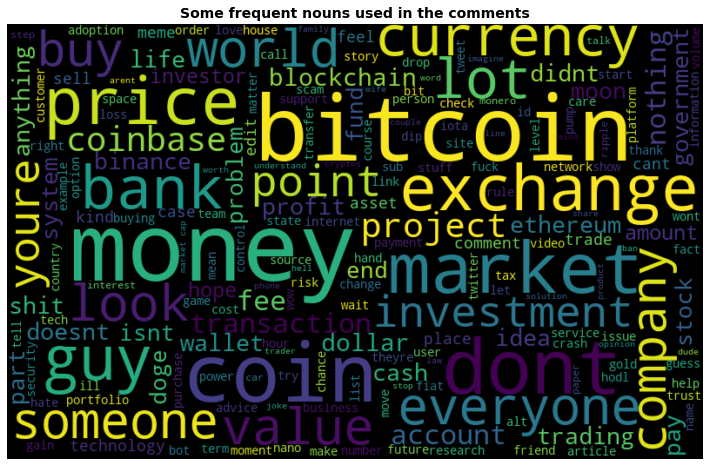

In [491]:
all_nouns = ' '.join([word for word in top_comments['nouns']])
all_nouns
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_nouns)
# wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', 
#                       colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(text)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent nouns used in the comments", weight='bold', fontsize=14)
plt.show()

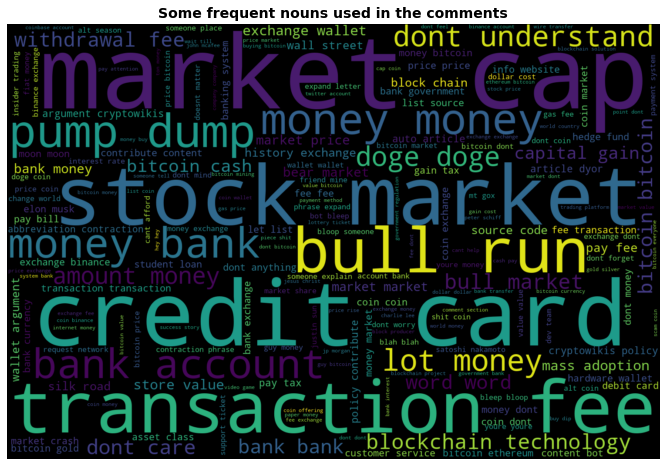

In [492]:
nltk_tokens = nltk.word_tokenize(all_words)  
bigrams_list = list(nltk.bigrams(top_comments['nouns']))
# print(bigrams_list)
dictionary2 = [' '.join(tup) for tup in bigrams_list]
# print (dictionary2)

#Using count vectoriser to view the frequency of bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2))
bag_of_words = vectorizer.fit_transform(dictionary2)
vectorizer.vocabulary_
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
# print (words_freq[:100])

#Generating wordcloud and saving as jpg image
words_dict = dict(words_freq)
WC_height = 1000
WC_width = 1500
WC_max_words = 200
wordCloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width)
wordCloud.generate_from_frequencies(words_dict)
plt.figure(figsize=(15, 8))
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent nouns used in the comments", weight='bold', fontsize=14)
plt.show()
# plt.title('Most frequently occurring bigrams connected by same colour and font size')
# plt.imshow(wordCloud, interpolation='bilinear')
# plt.axis("off")
# plt.show()

# Topic Modeling

In [493]:
comments = list(top_comments['cleaned_comments'])

topics = 3
topic_words = 20
topic_names = None
maxdf = None
mindf = 150

### Count Vectorization

In [494]:
cv = CountVectorizer(stop_words=stop, ngram_range=(1,3),  min_df = mindf)
X_cv = cv.fit_transform(comments)
pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names())

,able,account,adoption,ago,almost,already,alt,always,amount,another,...,working,world,worth,wow,wrong,xrp,yeah,yes,yet,youre
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18616,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18617,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18618,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18619,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Latent Semantic Analysis (LSA) with Count Vectorization

In [495]:
lsa_cv = TruncatedSVD(topics)
X_lsa_cv = lsa_cv.fit_transform(X_cv)
lsa_cv.explained_variance_ratio_

array([0.06418942, 0.02836404, 0.02622016])

In [496]:
display_topics(lsa_cv, cv.get_feature_names(), topic_words, topic_names)


Topic  0
money, bitcoin, coin, dont, make, market, bank, buy, btc, going, go, exchange, new, still, price, good, back, take, value, right

Topic  1
bitcoin, gold, cash, btc, future, real, ethereum, new, article, value, worth, whole, always, used, million, payment, saying, dollar, better, fact

Topic  2
coin, buy, price, btc, bitcoin, good, back, sell, market, dont, stock, make, someone, bought, long, eth, pump, shit, still, top


In [497]:
# topic_matrix(lsa_cv, cv.get_feature_names(), topics)

In [498]:
# prob_df(X_lsa_cv, topics)

#### Non-Negative Matrix Factorization (NMF) with Count Vectorization

In [499]:
nmf_cv = NMF(topics)
X_nmf_cv = nmf_cv.fit_transform(X_cv)
# nmf_cv.explained_variance_ratio_

In [500]:
display_topics(nmf_cv, cv.get_feature_names(), topic_words, topic_names)


Topic  0
coin, dont, market, make, buy, btc, price, go, going, back, still, good, money, right, eth, take, lot, many, value, company

Topic  1
bitcoin, btc, new, gold, cash, value, future, real, ethereum, used, always, worth, doesnt, well, million, take, dollar, better, look, say

Topic  2
bank, money, exchange, account, currency, financial, government, transaction, system, fee, new, fund, make, tax, blockchain, using, pay, fiat, asset, investment


In [501]:
# topic_matrix(nmf_cv, cv.get_feature_names(), topics)

In [502]:
# prob_df(X_nmf_cv, topics)

## TF-IDF Vectorizer

In [503]:
tfid = TfidfVectorizer(stop_words= stop, ngram_range=(2,3), min_df=10)
X_tfid = tfid.fit_transform(comments)
pd.DataFrame(X_tfid.toarray(), columns=tfid.get_feature_names())

,abbreviation contraction,abbreviation contraction phrase,able buy,abstract history,abstract history exchange,accept bitcoin,accepting bitcoin,acronym initialisms,acronym initialisms abbreviation,afford lose,...,wonder many,working product,worth bitcoin,worth btc,wouldnt surprised,xb gif,youre going,youre saying,youtube channel,youtube video
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18617,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18618,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Non-Negative Matrix Factorization (NMF) with TF-IDF Vectorization 

In [504]:
nmf_tfid = NMF(2)
X_nmf_tfid = nmf_tfid.fit_transform(X_tfid)

In [505]:
display_topics(nmf_tfid, tfid.get_feature_names(), topic_words, topic_names)


Topic  0
market cap, btc eth, billion dollar, stock market, cant wait, shit coin, lot money, amount money, put money, capital gain, withdrawal fee, asset class, stay away, fiat currency, scam coin, cold wallet, many coin, erc token, digital currency, million dollar

Topic  1
bull run, long term, bear market, buy bitcoin, btc eth, go back, bull market, buy back, short term, top coin, wall street, still dont, someone explain, id love, request network, vast majority, someone else, may well, john mcafee, take profit


In [506]:
# topic_matrix(nmf_tfid, tfid.get_feature_names(), topics)

In [507]:
# prob_df(X_nmf_tfid, topics)

## Word2Vec

In [ ]:
tokenized_comments = [gensim.utils.simple_preprocess(d) for d in comments]

# size refers to the desired dimension of our word vectors
# window refers to the size of our context window
# sg means that we are using the Skip-gram architecture

word2vec = gensim.models.Word2Vec(tokenized_comments, size=10, window=2,min_count=1)

# Path to where the word2vec file lives
google_vec_file = '/Users/racheldilley/Downloads/GoogleNews-vectors-negative300.bin'

# Load it!  This might take a few minutes...
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(google_vec_file, binary=True)

In [ ]:
word2vec.most_similar('doge')

In [ ]:
print(word2vec.train(comments, total_examples=word2vec.corpus_count, epochs=word2vec.epochs))

In [ ]:
word2vec.wv

In [ ]:
class WordVecVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = 300
    def fit(self, X, y):
        return self
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in texts.split() if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for texts in X
        ])

wtv = WordVecVectorizer(word2vec_model)
X_wtv = wtv.transform(comments)
print(X_wtv)

In [ ]:
print(word2vec_model.wv.vocab.keys())

In [ ]:
lsa_wtv = TruncatedSVD(topics)
X_lsa_wtv = lsa_tfid.fit_transform(X_wtv)
# lsa_wtv.explained_variance_ratio_

In [ ]:
display_topics(lsa_wtv, word2vec_model.wv.vocab.keys(), topic_words, topic_names)

## GloVe

In [ ]:
# from sklearn.cluster import KMeans
# km = KMeans(
#     n_clusters=2, init='random',
#     n_init=10, max_iter=300, 
#     tol=1e-04, random_state=0
# )
# y_km = km.fit_predict(X_wtv)
# df = pd.DataFrame({'year' :comments, 'topic_cluster' :y_km })
# df

In [ ]:
# from sklearn.manifold import TSNE
# model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
#                         n_iter=1000, verbose=1, random_state=0, angle=0.75)
# tsne_features = model.fit_transform(lda_matrix)
# df = pd.DataFrame(tsne_features)
# df['topic'] = lda_matrix.argmax(axis=1)
# df.columns = ['TSNE1', 'TSNE2', 'topic']
# import seaborn as sns
# plt.figure(figsize=(15, 10))
# plt.title('T-SNE plot of different headlines ( headlines are clustered among their topics)')
# ax = sns.scatterplot(x = 'TSNE1', y = 'TSNE2', hue = 'topic', data = df, legend = 'full')
# plt.show()

In [ ]:
# def get_top_n_words(corpus, n=10):
#   vec = CountVectorizer(stop_words='english').fit(corpus)
#   bag_of_words = vec.transform(corpus)
#   sum_words = bag_of_words.sum(axis=0) 
#   words_freq = [(word, sum_words[0, idx]) for word, idx in   vec.vocabulary_.items()]
#   words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
#   return words_freq[:n]
# words = []
# word_values = []
# for i,j in get_top_n_words(headlines['headline_text'],15):
#   words.append(i)
#   word_values.append(j)
# fig, ax = plt.subplots(figsize=(16,8))
# ax.bar(range(len(words)), word_values);
# ax.set_xticks(range(len(words)));
# ax.set_xticklabels(words, rotation='vertical');
# ax.set_title('Top 15 words in the headlines dataset');
# ax.set_xlabel('Word');
# ax.set_ylabel('Number of occurences');
# plt.show()


In [ ]:
# from wordcloud import WordCloud
# all_words = ''.join([word for word in headlines['headline_text'][0:100000]])
# all_words
# wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
# plt.figure(figsize=(15, 8))
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis('off')
# plt.title("Some frequent words used in the headlines", weight='bold', fontsize=14)
# plt.show()